In [62]:
'''Big thanks to Idiot Developer ❤'''
## https://www.youtube.com/watch?v=WVOMGekzbWE

'Big thanks to Idiot Developer ❤'

## Get Dataset and install need libs

In [1]:
!gdown 1XOBoRGSraP50_pS1YPB8_i8Wmw_5L-NG
!pip install imagesize

import tarfile
file = tarfile.open('/content/LaPa.tar.gz')
file.extractall('/content/')
file.close()

!rm /content/LaPa.tar.gz

Downloading...
From (original): https://drive.google.com/uc?id=1XOBoRGSraP50_pS1YPB8_i8Wmw_5L-NG
From (redirected): https://drive.google.com/uc?id=1XOBoRGSraP50_pS1YPB8_i8Wmw_5L-NG&confirm=t&uuid=3199e1e7-b850-4bc2-8465-6a1d55806b8e
To: /content/LaPa.tar.gz
100% 2.37G/2.37G [00:36<00:00, 64.6MB/s]


## IMPORTS and Hyperparameters

In [2]:
import os
import numpy as np
import cv2
from glob import glob
import imagesize
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers as tfkl
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, CSVLogger


In [17]:
global image_h, image_w, image_c, input_shape, num_landmarks, batch_size, lr, epochs, seed, load_norm_csv, shuffle, reshuffle_each_iteration

'''---HyparParameters---'''
image_h = 512
image_w = 512
image_c = 3
num_landmarks = 106
input_shape = (image_h, image_w, image_c)
#############
batch_size = 64
lr = 1e-3 #try 1e-2 or 5e-3
epochs = 30
#############
shuffle = True
seed = 42
reshuffle_each_iteration = True
#############
load_norm_csv = True
#############
tf.random.set_seed(seed)
np.random.seed(seed)

'''---Paths---'''
dataset_path = '/content/LaPa'
model_path = '/content/drive/MyDrive/DataSets/Facial_Landmark_Detection/results/model.h5'
csv_path = '/content/drive/MyDrive/DataSets/Facial_Landmark_Detection/results/logs.csv'
landnorm_path = '/content/drive/MyDrive/DataSets/Facial_Landmark_Detection/'


## Helper_functions

In [ ]:
def load_dataset(path):
  train_x = sorted(glob(os.path.join(path, 'train', 'images', '*.jpg')))
  train_y = sorted(glob(os.path.join(path, 'train', 'landmarks', '*.txt')))

  valid_x = sorted(glob(os.path.join(path, 'val', 'images', '*.jpg')))
  valid_y = sorted(glob(os.path.join(path, 'val', 'landmarks', '*.txt')))

  test_x = sorted(glob(os.path.join(path, 'test', 'images', '*.jpg')))
  test_y = sorted(glob(os.path.join(path, 'test', 'landmarks', '*.txt')))

  return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

In [ ]:
def landmarks_txt_to_csv(listOfTxt_paths, listOfimg_paths, outpath):
  header = "num_landmarks,"
  for i in range(106):
    header += f'x{i+1},y{i+1},'

  with open(outpath, 'w') as mw:
    mw.write(header[0:-1])
    mw.write('\n')
    mw.close()

  for txt in listOfTxt_paths:
    data = open(txt, 'r').read()
    data = data.strip().replace('\n', ',').replace(' ', ',')
    with open(outpath, 'a') as mf:
      mf.write(data)
      mf.write('\n')
      mf.close()

In [ ]:
## Normalize image landmarks wrt w, h
def landmark_norm(train_x, train_y):
  w, h = imagesize.get(train_x[0])
  wh = np.array([w,h]*106)
  ls = np.divide(train_y.iloc[0].values, wh)
  ls = ls.astype(dtype=np.float32)

  for i in range(1, len(train_x)):
    w, h = imagesize.get(train_x[i])
    wh = np.array([w,h]*106)
    norm = np.divide(train_y.iloc[i].values, wh)
    ls = np.vstack([ls, norm]).astype(dtype=np.float32)
  return ls

In [ ]:
def data_pipeline(input:tuple, parse_function, batch_size, shuffle, seed, reshuffle_each_iteration):
  with tf.device('/cpu:0'):
    data_set = tf.data.Dataset.from_tensor_slices(input)
    if shuffle:
      data_set = data_set.shuffle(len(input[0]), seed=seed, reshuffle_each_iteration=reshuffle_each_iteration)
    data_set = data_set.map(parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    data_set = data_set.batch(batch_size)
    data_set = data_set.prefetch(tf.data.experimental.AUTOTUNE)
  return data_set


def parse_function(file_path, landmarks):
  ## image preprocessing
  image_string = tf.io.read_file(file_path)
  image = tf.image.decode_jpeg(image_string, channels=image_c)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize(image, [image_h, image_w])

  return image, landmarks


def parse_custom(file_path):
  ## image preprocessing
  image_string = tf.io.read_file(file_path)
  image = tf.image.decode_jpeg(image_string, channels=image_c)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize(image, [image_h, image_w])
  return image

In [ ]:
### Another way for data pipelining

# def preprocess(x, y):
#     def f(x, y):
#         x = x.decode()
#         y = y.decode()

#         image, landmarks = read_image_lankmarks(x, y)
#         return image, landmarks

#     image, landmarks = tf.numpy_function(f, [x, y], [tf.float32, tf.float32])
#     image.set_shape([image_h, image_w, 3])
#     landmarks.set_shape([num_landmarks * 2])

#     return image, landmarks

# def tf_dataset(x, y, batch=8):
#     ds = tf.data.Dataset.from_tensor_slices((x, y))
#     ds = ds.shuffle(buffer_size=5000).map(preprocess)
#     ds = ds.batch(batch).prefetch(2)
#     return ds

In [51]:
def plot_one(x, y, ax, color:tuple, title):
  for gg in y.reshape(-1,2):
    gg = np.multiply(gg, [image_w,image_h]).astype(dtype=np.int16)
    x = cv2.circle(x, (gg[0],gg[1]), 4, color, -1)
  ax.imshow(x)
  ax.axis('off')
  if title:
    ax.set_title(title)

## Get Dataset ready to Pipeline

In [4]:
(train_x, train_y), (valid_x, valid_y), (test_x, test_y)= load_dataset(dataset_path)
(len(train_x), len(train_y)), (len(valid_x), len(valid_y)), (len(test_x), len(test_y))

((18168, 18168), (2000, 2000), (2000, 2000))

In [6]:
if load_norm_csv:
  train_y_norm = np.load(landnorm_path + 'train_norm_landmarks.npy')
  valid_y_norm = np.load(landnorm_path + 'val_norm_landmarks.npy')
  test_y_norm = np.load(landnorm_path + 'test_norm_landmarks.npy')
else:
  landmarks_txt_to_csv(train_y, train_x , dataset_path + '/train/train_landmarks.csv')
  landmarks_txt_to_csv(valid_y, valid_x , dataset_path + '/val/val_landmarks.csv')
  landmarks_txt_to_csv(test_y, test_x ,  dataset_path + '/test/test_landmarks.csv')

  train_y = pd.read_csv(dataset_path + '/train/train_landmarks.csv').iloc[:,1:]
  valid_y = pd.read_csv(dataset_path + '/val/val_landmarks.csv').iloc[:,1:]
  test_y = pd.read_csv(dataset_path + '/test/test_landmarks.csv').iloc[:,1:]

  train_y_norm = landmark_norm(train_x, train_y)
  valid_y_norm = landmark_norm(valid_x, valid_y)
  test_y_norm = landmark_norm(test_x, test_y)

  np.save(landnorm_path + 'train_norm_landmarks.npy', train_y_norm)
  np.save(landnorm_path + 'val_norm_landmarks.npy', valid_y_norm)
  np.save(landnorm_path + 'test_norm_landmarks.npy', test_y_norm)


## DataPipeLine

In [24]:
training_set = data_pipeline((train_x, train_y_norm), parse_function, batch_size, shuffle, seed, reshuffle_each_iteration)
validation_set = data_pipeline((valid_x, valid_y_norm), parse_function, batch_size, shuffle, seed, reshuffle_each_iteration)


## Little bit visualization Training

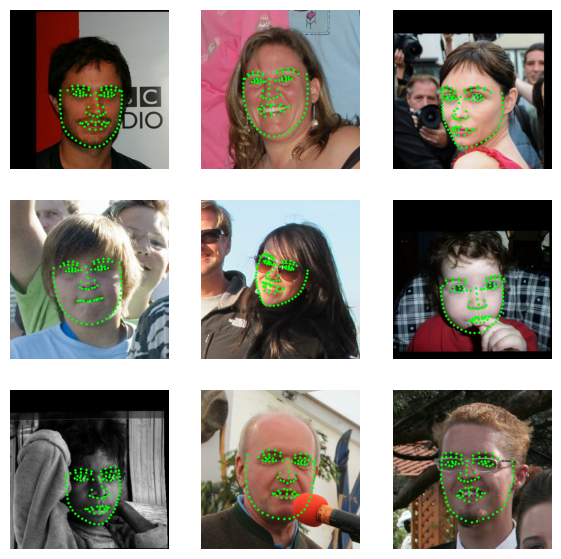

In [48]:
fig, axs = plt.subplots(3,3, figsize=(7,7))
axs = axs.ravel()
for i, (x, y) in enumerate(training_set.unbatch().take(9)):
  plot_one(x.numpy(), y.numpy(), axs[i], (0,1,0), None)

## Model Build and Training

In [ ]:
def build_model(inshape, num_landmarks):
  inputs = tfkl.Input(inshape)
  backbone = MobileNetV2(include_top=False, weights="imagenet", alpha=0.5, input_tensor=inputs)
  backbone.trainable = True

  x = backbone.output
  x = tfkl.GlobalAveragePooling2D()(x)
  x = tfkl.Dropout(0.2)(x)

  outputs = tfkl.Dense(num_landmarks*2, activation="sigmoid")(x)
  model = tf.keras.models.Model(inputs, outputs)
  return model

In [ ]:
model = build_model(input_shape, num_landmarks)
model.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(lr))


3201480/3201480 [==============================] - 0s 0us/step


In [ ]:
callbacks = [
        ModelCheckpoint(model_path, verbose=1, save_best_only=True, monitor='val_loss'),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
        CSVLogger(csv_path, append=True),
        EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False)]

model.fit(training_set, validation_data=validation_set,
          epochs=epochs, callbacks=callbacks)

Epoch 1/30
284/284 [==============================] - ETA: 0s - loss: 0.6576
Epoch 1: val_loss improved from inf to 1.29166, saving model to /content/drive/MyDrive/DataSets/Facial_Landmark_Detection/results/model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


284/284 [==============================] - 247s 733ms/step - loss: 0.6576 - val_loss: 1.2917 - lr: 0.0010
Epoch 2/30
284/284 [==============================] - ETA: 0s - loss: 0.6548
Epoch 2: val_loss improved from 1.29166 to 0.96372, saving model to /content/drive/MyDrive/DataSets/Facial_Landmark_Detection/results/model.h5
284/284 [==============================] - 202s 707ms/step - loss: 0.6548 - val_loss: 0.9637 - lr: 0.0010
Epoch 3/30
284/284 [==============================] - ETA: 0s - loss: 0.6543
Epoch 3: val_loss improved from 0.96372 to 0.73049, saving model to /content/drive/MyDrive/DataSets/Facial_Landmark_Detection/results/model.h5
284/284 [==============================] - 200s 704ms/step - loss: 0.6543 - val_loss: 0.7305 - lr: 0.0010
Epoch 4/30
284/284 [==============================] - ETA: 0s - loss: 0.6542
Epoch 4: val_loss improved from 0.73049 to 0.69624, saving model to /content/drive/MyDrive/DataSets/Facial_Landmark_Detection/results/model.h5
284/284 [=============

## Model performance

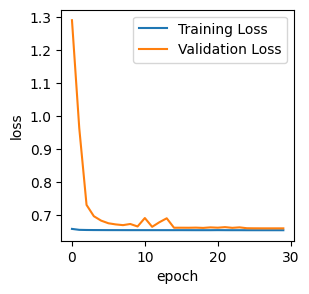

In [ ]:
## Plot performance
plt.figure(figsize=(3,3))
csv = pd.read_csv(csv_path)
plt.plot(csv['epoch'], csv['loss'], label='Training Loss')
plt.plot(csv['epoch'], csv['val_loss'], label='Validation Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

1/1 [==============================] - 0s 100ms/step


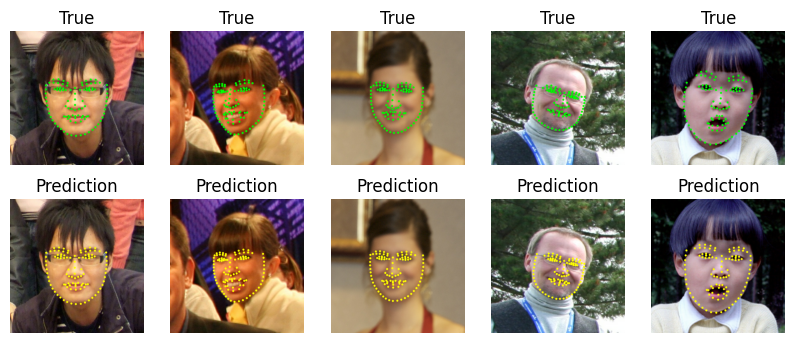

In [61]:
n = 5

fig, axs = plt.subplots(2,n, figsize=(10,4))
axs = axs.T
for (xt, y), ax in zip(validation_set.unbatch().take(n), axs):
  y_hat = model.predict(np.expand_dims(xt, axis=0))
  xt = xt.numpy()
  xh = xt.copy()
  plot_one(xt, y.numpy(), ax[0], (0,1,0), 'True')
  plot_one(xh, y_hat, ax[1], (1,1,0), 'Prediction')

## TEST MODEL

In [34]:
test_set = data_pipeline((test_x, test_y_norm), parse_function, batch_size, shuffle, seed, reshuffle_each_iteration)

model = tf.keras.models.load_model(model_path)

In [ ]:
model.evaluate(test_set)

32/32 [==============================] - 292s 9s/step - loss: 0.6599


0.6599448919296265

1/1 [==============================] - 0s 277ms/step


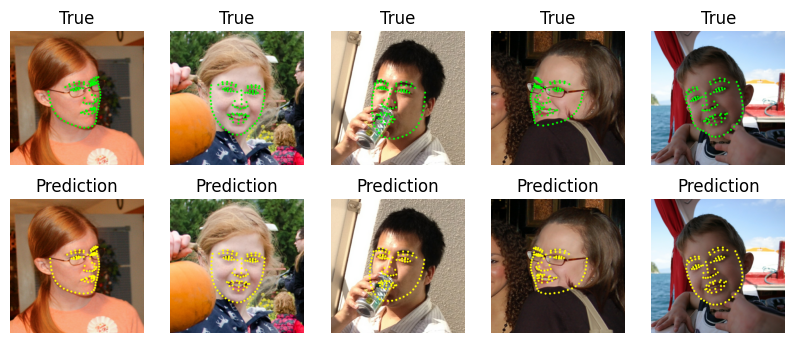

In [54]:
n = 5

fig, axs = plt.subplots(2,n, figsize=(10,4))
axs = axs.T
for (xt, y), ax in zip(test_set.unbatch().take(n), axs):
  y_hat = model.predict(np.expand_dims(xt, axis=0))
  xt = xt.numpy()
  xh = xt.copy()
  plot_one(xt, y.numpy(), ax[0], (0,1,0), 'True')
  plot_one(xh, y_hat, ax[1], (1,1,0), 'Prediction')

## Custom images test

In [37]:
custom_dir = '/content/drive/MyDrive/DataSets/Facial_Landmark_Detection/custom'
custom_x = glob(custom_dir+'/*.jpg')

In [58]:
custom_set = data_pipeline((custom_x), parse_custom, batch_size, shuffle, seed, reshuffle_each_iteration)

1/1 [==============================] - 0s 84ms/step


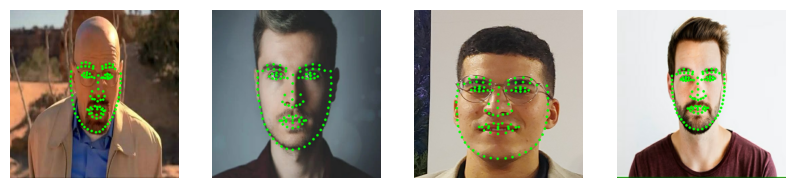

In [60]:
n = len(custom_x)
fig, axs = plt.subplots(1,n, figsize=(10,7))
axs = axs.ravel()
for i, (x) in enumerate(custom_set.unbatch().take(n)):
  x = x.numpy()
  y = model.predict(np.expand_dims(x, axis=0))
  plot_one(x, y, axs[i], (0,1,0), None)